In [59]:
from __future__ import division
import os
import numpy as np
import cv2
import random
import requests
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import nn

In [44]:
FACE_PATH = "/home/alex/Desktop/Face Detection/Face Detect/Positive/"
NON_FACE_PATH = "/home/alex/Desktop/Face Detection/Face Detect/Negative/"
IN_SIZE = (32,32)   #Input dimensions of image for the network
SNAP_COUNT = 5      #Number of random snapshots per non-face image
MIN_LEN = 10        #Minimum length for the random snaphsots of non-faces
GOOD = [1,0]
BAD = [0,1]

FACE_COUNT = 30000
TRAIN_SPLIT = int(0.7*FACE_COUNT)

DET_SIZE = (300,300)    #Run all localization at a standard size
IN_SIZE = (32,32)   #Input dimensions of image for the network
BLUR_DIM = (50,50)      #Dimension for blurring the face location mask
CONF_THRESH = 0.999      #Confidence threshold to mark a window as a face

X_STEP = 10     #Horizontal slide for the sliding window
Y_STEP = 10     #Vertical stride for the sliding window
WIN_MIN = 40    #Minimum sliding window size
WIN_MAX = 100   #Maximum sliding window size
WIN_STRIDE = 10   #Stride to increase the sliding window


SAVE_PATH = "/home/alex/Desktop/Face-Detection-Recognition/model/"

In [4]:
#Method to generate multiple snapshots from an image
def rand_snap(img):
    r = []
    x = img.shape[0]
    y = img.shape[1]
    #Generate 5 snapshots of different sizes
    for i in range(SNAP_COUNT):
        snap_size = max([MIN_LEN,int(random.random()*200)])
        fx = int(random.random()*(x-snap_size))
        fy = int(random.random()*(y-snap_size))
        snap = img[fx:fx+snap_size,fy:fy+snap_size]
        r.append(cv2.resize(snap,IN_SIZE))
    return r

#Load the dataset for face/non face classification
def load_find_ds():
    ds = []
    #Load faces (positive samples)
    for n in os.listdir(FACE_PATH):
        name = FACE_PATH+n
        for img_path in os.listdir(name):
            t_img = cv2.resize(cv2.imread(name+"/"+img_path,0),IN_SIZE)
            ds.append((t_img, GOOD))
            ds.append((cv2.flip(t_img,1),GOOD)) #Use the horizontal mirror image
    random.shuffle(ds)
    ds = ds[:FACE_COUNT] 
    #Load non-faces (negative samples) from dataset
    nface_ds = []
    for n in os.listdir(NON_FACE_PATH):
        name = NON_FACE_PATH+n
        for img_path in os.listdir(name):
            t_img = cv2.imread(name+"/"+img_path,0)
            nface_ds.extend([(r,BAD) for r in rand_snap(t_img)])
            nface_ds.append((cv2.resize(t_img, IN_SIZE),BAD))
    random.shuffle(nface_ds)
    nface_ds = nface_ds[:FACE_COUNT]

    #Make the train, val and test sets: Ensure 50% for each set
    train = ds[:TRAIN_SPLIT]
    train.extend(nface_ds[:TRAIN_SPLIT])
    random.shuffle(train)
    test = ds[TRAIN_SPLIT:]
    test.extend(nface_ds[TRAIN_SPLIT:])
    random.shuffle(test)

    trainX,trainY = map(np.array,zip(*train))
    testX,testY = map(np.array,zip(*test))

    return ((trainX,trainY),(testX,testY))

In [5]:
((trainX,trainY),(testX,testY)) = load_find_ds()

In [6]:
print(trainX.shape)
print(testX.shape)

(42000, 32, 32)
(18000, 32, 32)


In [7]:
sum(trainY)+sum(testY)

array([30000, 30000])

In [8]:
#Build the net in the session
def build_net(sess):
    in_len = 32
    in_dep = 1

    x_hold = tf.placeholder(tf.float32,shape=[None,in_dep*in_len*in_len])
    y_hold = tf.placeholder(tf.float32,shape=[None,2])
    keep_prob = tf.placeholder(tf.float32)

    xt = tf.reshape(x_hold,[-1,in_len,in_len,in_dep])

    xt = tf.layers.batch_normalization(xt)
    
    #Layer 1 - 3x3 convolution
    w1 = tf.Variable(tf.truncated_normal([3,3,in_dep,4], stddev=0.1))
    b1 = tf.Variable(tf.constant(0.1, shape=[4]))
    c1 = nn.relu(nn.conv2d(xt,w1,strides=[1,2,2,1],padding='VALID')+b1)
    o1 = nn.max_pool(c1, [1,2,2,1], [1,2,2,1], padding='VALID')
    #o1 = tf.layers.batch_normalization(o1)
    
    print("o1 shape: {}".format(o1.shape))
    
    #Layer 2 - 3x3 convolution
    w2 = tf.Variable(tf.truncated_normal([3,3,4,16], stddev=0.1))
    b2 = tf.Variable(tf.constant(0.1, shape=[16]))
    c2 = nn.relu(nn.conv2d(o1,w2,strides=[1,2,2,1],padding='VALID')+b2)
    o2 = c2
    print("o2 shape: {}".format(o2.shape))
    
    #o3 = o2
    
    #Layer 3 - 3x3 convolution
    w3 = tf.Variable(tf.truncated_normal([3,3,16,32], stddev=0.1))
    b3 = tf.Variable(tf.constant(0.1, shape=[32]))
    c3 = nn.relu(nn.conv2d(o2,w3,strides=[1,1,1,1],padding='VALID')+b3)
    o3 = o2
 
    print("o3 shape: {}".format(o3.shape))
    
    
    dim = 9*4*4
        
    #Fully connected layer - 600 units
    of = tf.reshape(o3,[-1,dim])
    w4 = tf.Variable(tf.truncated_normal([dim,600], stddev=0.1))
    b4 = tf.Variable(tf.constant(0.1, shape=[600]))
    o4 = nn.relu(tf.matmul(of,w4)+b4)

    o4 = nn.dropout(o4, keep_prob)

    print("o4 shape: {}".format(o4.shape))
    
    
    
    #Output softmax layer - 2 units
    w5 = tf.Variable(tf.truncated_normal([600,2], stddev=0.1))
    b5 = tf.Variable(tf.constant(0.1, shape=[2]))
    y = nn.softmax(tf.matmul(o4,w5)+b5)

    sess.run(tf.global_variables_initializer())

    return y,x_hold,y_hold,keep_prob

In [9]:
#Finds the product of a dimension tuple to find the total legth
def dim_prod(dim_arr):
    return np.prod([d for d in dim_arr if d != None])

#Split to mini batches
def batchify(X, Y, batch_size):
    batches = [(X[i:i+batch_size],Y[i:i+batch_size]) for i in range(0,X.shape[0],batch_size)]
    random.shuffle(batches)
    return batches

In [10]:
#Start a TensorFlow session
def start_sess():
    config = tf.ConfigProto()
    config.gpu_options.allocator_type = 'BFC'
    sess = tf.Session(config=config)
    return sess

#Train the model
def ftrain(sess, y, x_hold, y_hold, keep_prob, X, Y, testX, testY, lrate=0.5, epsilon=1e-8, n_epoch=100, batch_size=10, print_epoch=100, save_path=None, plot_acc=None):
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_hold*tf.log(y+1e-10), reduction_indices=[1]))
    
    correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(y_hold,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    acc_X = []
    acc_Y = []
    
    train_step = tf.train.AdamOptimizer(learning_rate=lrate,epsilon=epsilon).minimize(cross_entropy)
    
    #Flatten the input images for the placeholder
    flat_len = dim_prod(x_hold._shape_as_list())
    X = X.reshape((X.shape[0],flat_len))

    print('Starting training session...')

    sess.run(tf.global_variables_initializer())
    batch_num = 0
    batches = batchify(X,Y,batch_size)
    print('Number of batches:',len(batches))
    for i in range(n_epoch):
        avg_acc = 0
        random.shuffle(batches)
        for batchX,batchY in batches:
            train_accuracy = accuracy.eval(session=sess, feed_dict={x_hold:batchX, y_hold:batchY, keep_prob:1})
            avg_acc = avg_acc + train_accuracy
            train_step.run(session=sess,feed_dict={x_hold:batchX, y_hold:batchY, keep_prob:0.75})
            #print('Epoch '+': '+str(train_accuracy))
        print('Epoch '+str(i)+': '+str(avg_acc/len(batches)))

        if (not testX is None) & (not testY is None):
            testX = testX.reshape((testX.shape[0],flat_len))
            test_accuracy = accuracy.eval(session=sess,feed_dict={x_hold:testX, y_hold:testY, keep_prob:1})
            #print('Acc test: ',test_accuracy)
            if plot_acc is not None:
                acc_Y.append(test_accuracy)
                acc_X.append(i)

    if not save_path is None:
        saver = tf.train.Saver()
        saver.save(sess, "/home/alex/Desktop/Face Detection/Face Detect/test_model/tm", global_step=1000)
        #merged = tf.summary.merge_all()
        #writer = tf.train.SummaryWriter(save_path+'_graph',sess.graph)
        #writer.flush()
        #writer.close()
        print('Model saved')
        
    if plot_acc is not None:
        plt.plot(acc_X, acc_Y, 'r')
        plt.show()
        
    return test_accuracy

In [33]:
#Method to run the training
def train_net():
    train,test = load_find_ds()
    sess = start_sess()
    y,x_hold,y_hold,keep_prob = build_net(sess)
    acc = ftrain(sess,
                y,
                x_hold,
                y_hold,
                keep_prob,
                train[0],train[1],
                test[0],test[1],
                lrate=1e-4,
                epsilon=1e-16,
                n_epoch=50,
                batch_size=100,
                print_epoch=1,
                save_path=True,
                plot_acc=True)
    print("Accuracy:",acc)
    return y,x_hold,y_hold,keep_prob, sess

o1 shape: (?, 7, 7, 4)
o2 shape: (?, 3, 3, 16)
o3 shape: (?, 3, 3, 16)
o4 shape: (?, 600)
Starting training session...
Number of batches: 420
Epoch 0: 0.7051428571343422
Epoch 1: 0.9150952391681217
Epoch 2: 0.9480000010558537
Epoch 3: 0.9591428607702255
Epoch 4: 0.9675000055914833
Epoch 5: 0.9744047718388694
Epoch 6: 0.9781190579845792
Epoch 7: 0.980976201522918
Epoch 8: 0.9835476304803575
Epoch 9: 0.9847381059612547
Epoch 10: 0.9870238192024685
Epoch 11: 0.9880238188164575
Epoch 12: 0.9892619138672238
Epoch 13: 0.9905238174256824
Epoch 14: 0.9915238168977556
Epoch 15: 0.9920952450661432
Epoch 16: 0.9928333398841677
Epoch 17: 0.9936190532786505
Epoch 18: 0.9941904814470381
Epoch 19: 0.99500000448454
Epoch 20: 0.9954047661452067
Epoch 21: 0.9957857183047704
Epoch 22: 0.9961904796816053
Epoch 23: 0.9966190508433751
Epoch 24: 0.996833336353302
Epoch 25: 0.9964761938367571
Epoch 26: 0.9971904788698469
Epoch 27: 0.9974047643797738
Epoch 28: 0.9978333353996277
Epoch 29: 0.9978095258985247
Ep

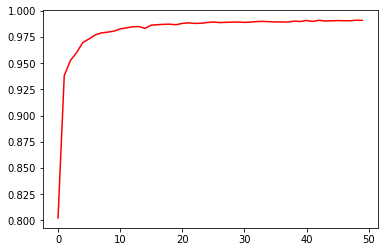

Accuracy: 0.991


In [114]:
y,x_hold,y_hold,keep_prob, sess = train_net()

In [117]:
def show_img(y,x_hold,y_hold,keep_prob, sess):
    img = cv2.imread("/home/alex/Desktop/Face Detection/Face Detect/trump.jpeg",0)
    
    plt.imshow(img, cmap='gray')
    plt.show()
    
    img = cv2.resize(img,DET_SIZE)
    mask = np.zeros(img.shape)
    #Run sliding windows of different sizes
    for bx in range(WIN_MIN,WIN_MAX,WIN_STRIDE):
        by = bx
        for i in range(0, img.shape[1]-bx, X_STEP):
            for j in range(0, img.shape[0]-by, Y_STEP):
                sub_img = cv2.resize(img[i:i+bx,j:j+by],IN_SIZE)
                X = sub_img.reshape((1,dim_prod(IN_SIZE)))
                out = y.eval(session=sess,feed_dict={x_hold:X,keep_prob:1})[0]
                if out[0] >= CONF_THRESH:
                    mask[i:i+bx,j:j+by] = mask[i:i+bx,j:j+by]+1

    mask = np.uint8(255*mask/np.max(mask))
    
    ymin = 300
    ymax = 0
    xmin = 300
    xmax = 0
    for i in range(img.shape[1]):
        for j in range(img.shape[0]):
            if mask[i,j] != 0:
                if ymin > i:
                    ymin = i
                if ymax < i:
                    ymax = i
                if xmin > j:
                    xmin = j
                if xmax < j:
                    xmax = j

    face_img = img[ymin:ymax, xmin:xmax]
    plt.imshow(face_img, cmap='gray')
    plt.show()

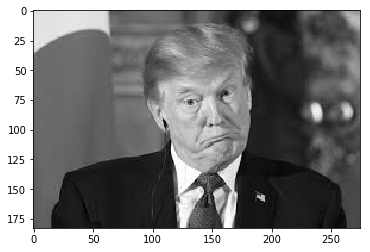

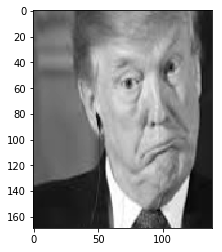

In [118]:
show_img(y,x_hold,y_hold,keep_prob, sess)